# Radiative heating regressed with precipitation

## Import package

In [7]:
import h5py
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import product

## Load data

In [8]:
# Load CloudSat data
RAD_PATH = "/work/b11209013/2025_Research/"

q_lw = {}; q_sw = {}; t_lw = {}; t_sw = {}

lon = np.linspace(180, 180, 576)
mid = lon.size // 2

for central_lon in range(0, 341, 20):
    
    with h5py.File(f"{RAD_PATH}moisture_rad.h5") as f:

        lon_centered = (lon - central_lon + 180) % 360 - 180
        target = np.argmin(np.abs(lon_centered))
        shift = mid-target

        q_lw[str(central_lon)] = np.roll(np.array(f.get("q_lw")), shift, axis=2)
        q_sw[str(central_lon)] = np.roll(np.array(f.get("q_sw")), shift, axis=2)
        t_lw[str(central_lon)] = np.roll(np.array(f.get("t_lw")), shift, axis=2)
        t_sw[str(central_lon)] = np.roll(np.array(f.get("t_sw")), shift, axis=2)

# Load IMERG time series data
IMERG_PATH = "/home/b11209013/2025_Research/Obs/Files/IMERG/Hovmoller.h5"

Hov = {}

with h5py.File(IMERG_PATH, "r") as f:
    lon = np.array(f.get("lon"))

    hov_grp = f.get("precip")

    Hov = {key: np.array(hov_grp.get(key)) for key in hov_grp.keys()}

## Compute regression

### Define functions

In [9]:
import numpy as np

def regression_slope(x, y):
    """Compute regression slope of y onto 1D x, vectorized over all grid points.
    
    Parameters
    ----------
    x : array_like, shape (nt,)
        Predictor time series.
    y : array_like, shape (nt, ...) 
        Predictand field with the same time dimension as x. Can be 2D, 3D, etc.
    
    Returns
    -------
    slope : ndarray, shape y.shape[1:]
        Regression slope at each grid point, with NaNs where regression is not defined.
    """
    # Convert to arrays
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    # Basic checks
    if x.ndim != 1:
        # Allow x to be (nt, 1, ..., 1) but collapse it
        x = x.reshape(x.shape[0], -1)
        if x.shape[1] != 1:
            raise ValueError("This implementation assumes x is a 1D time series (nt,).")
        x = x[:, 0]

    if y.shape[0] != x.shape[0]:
        raise ValueError("Time dimension of x and y must match (x.shape[0] == y.shape[0]).")

    nt = x.shape[0]
    # Flatten spatial dims of y: (nt, npoints)
    y_flat = y.reshape(nt, -1)                      # (nt, M)
    M = y_flat.shape[1]

    # Broadcast x to shape (nt, M)
    x2d = x[:, None]                                # (nt, 1)

    # Valid (non-NaN) mask per time & point
    mask = ~np.isnan(y_flat) & ~np.isnan(x2d)       # (nt, M)

    # Number of valid samples per point
    n = np.sum(mask, axis=0)                        # (M,)

    # Zero out invalid entries for sums
    x_masked = np.where(mask, x2d, 0.0)             # (nt, M)
    y_masked = np.where(mask, y_flat, 0.0)          # (nt, M)

    # Sums over time for each grid point
    sum_x  = np.sum(x_masked, axis=0)               # (M,)
    sum_y  = np.sum(y_masked, axis=0)               # (M,)
    sum_xx = np.sum(x_masked * x_masked, axis=0)    # (M,)
    sum_xy = np.sum(x_masked * y_masked, axis=0)    # (M,)

    # Closed-form slope per grid point
    denom = n * sum_xx - sum_x**2
    numer = n * sum_xy - sum_x * sum_y

    slope_flat = np.full(M, np.nan, dtype=float)
    valid_reg = (n > 1) & (denom != 0.0)
    slope_flat[valid_reg] = numer[valid_reg] / denom[valid_reg]

    # Back to original spatial shape
    slope = slope_flat.reshape(y.shape[1:])
    return slope


### Compute regression

In [10]:
# Compute regression
q_lw_reg = {}
q_sw_reg = {}
t_lw_reg = {}
t_sw_reg = {}

for lw_key in q_lw.keys():
    # preallocate dict
    q_lw_reg[str(lw_key)] = {}
    q_sw_reg[str(lw_key)] = {}
    t_lw_reg[str(lw_key)] = {}
    t_sw_reg[str(lw_key)] = {}

    # find longitude index
    lon_idx = np.argmin(np.abs(lon - (int(lw_key))))

    for hov_key in tqdm(Hov.keys(), desc=f"Processing LW key {lw_key}"):
        Hov_ts = Hov[hov_key][:, lon_idx]

        q_lw_reg[str(lw_key)][str(hov_key)] = regression_slope(Hov_ts[:,None,None], q_lw[lw_key])
        q_sw_reg[str(lw_key)][str(hov_key)] = regression_slope(Hov_ts[:,None,None], q_sw[lw_key])
        t_lw_reg[str(lw_key)][str(hov_key)] = regression_slope(Hov_ts[:,None,None], t_lw[lw_key])
        t_sw_reg[str(lw_key)][str(hov_key)] = regression_slope(Hov_ts[:,None,None], t_sw[lw_key])

Processing LW key 340: 100%|██████████| 7/7 [00:17<00:00,  2.45s/it]


### Compute average values

In [11]:
q_lw_reg_composite = {
    hov_key: np.nanmean(
        np.array([q_lw_reg[lw_key][hov_key] for lw_key in q_lw.keys()]),
        axis=0
    )
    for hov_key in Hov.keys()
}

q_sw_reg_composite = {
    hov_key: np.nanmean(
        np.array([q_sw_reg[lw_key][hov_key] for lw_key in q_sw.keys()]),
        axis=0
    )
    for hov_key in Hov.keys()    
}

t_lw_reg_composite = {
    hov_key: np.nanmean(
        np.array([t_lw_reg[lw_key][hov_key] for lw_key in t_lw.keys()]),
        axis=0
    )
    for hov_key in Hov.keys()    
}

t_sw_reg_composite = {
    hov_key: np.nanmean(
        np.array([t_sw_reg[lw_key][hov_key] for lw_key in t_sw.keys()]),
        axis=0
    )
    for hov_key in Hov.keys()
}

## Save File

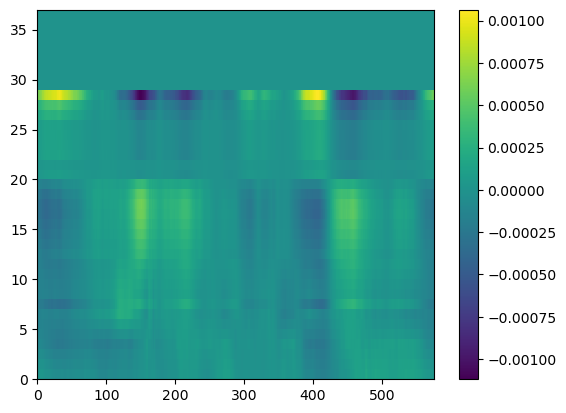

In [13]:
with h5py.File("/work/b11209013/2025_Research/regression/IMERG_MOISTRAD.h5", "w") as f:
    q_lw_grp = f.create_group("q_lw")

    for hov_key in Hov.keys():
        q_lw_grp_hov = q_lw_grp.create_group(str(hov_key))
        for lw_key in q_lw.keys():
            q_lw_grp_hov.create_dataset(str(lw_key), data=np.array(q_lw_reg[str(lw_key)][str(hov_key)]))

    q_sw_grp = f.create_group("q_sw")

    for hov_key in Hov.keys():
        q_sw_grp_hov = q_sw_grp.create_group(str(hov_key))
        for sw_key in q_sw.keys():
            q_sw_grp_hov.create_dataset(str(sw_key), data=np.array(q_sw_reg[str(sw_key)][str(hov_key)]))

    t_lw_grp = f.create_group("t_lw")

    for hov_key in Hov.keys():
        t_lw_grp_hov = t_lw_grp.create_group(str(hov_key))
        for lw_key in t_lw.keys():
            t_lw_grp_hov.create_dataset(str(lw_key), data=np.array(t_lw_reg[str(lw_key)][str(hov_key)]))

    t_sw_grp = f.create_group("t_sw")

    for hov_key in Hov.keys():
        t_sw_grp_hov = t_sw_grp.create_group(str(hov_key))
        for sw_key in t_sw.keys():
            t_sw_grp_hov.create_dataset(str(sw_key), data=np.array(t_sw_reg[str(sw_key)][str(hov_key)]))

    q_lw_comp_grp = f.create_group("q_lw_composite")
    plt.pcolormesh(np.array(q_lw_reg_composite["kw_1_3"]))
    plt.colorbar()
    plt.show()

    for hov_key in Hov.keys():
        q_lw_comp_grp.create_dataset(str(hov_key), data=np.array(q_lw_reg_composite[str(hov_key)]))

    q_sw_comp_grp = f.create_group("q_sw_composite")

    for hov_key in Hov.keys():
        q_sw_comp_grp.create_dataset(str(hov_key), data=np.array(q_sw_reg_composite[str(hov_key)]))

    t_lw_comp_grp = f.create_group("t_lw_composite")
    
    for hov_key in Hov.keys():
        t_lw_comp_grp.create_dataset(str(hov_key), data=np.array(t_lw_reg_composite[str(hov_key)]))

    t_sw_comp_grp = f.create_group("t_sw_composite")

    for hov_key in Hov.keys():
        t_sw_comp_grp.create_dataset(str(hov_key), data=np.array(t_sw_reg_composite[str(hov_key)]))